# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS-S109A Introduction to Data Science 

## Lecture 6: Classification and Logistic Regression

**Harvard University**<br>
**Summer 2020**<br>
**Instructors:** Kevin Rader<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner, Kevin Rader

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Logistic Regression</li> 
<li> More Logistic Regression </li> 
<li> Classification Accuracy</li>

    

## Learning Goals

This Jupyter notebook accompanies Lecture 6. By the end of this lecture, you should be able to:

- Fit, plot, and interpret logistic regression models
- Fit and interpret multinomial logistic regression models
- Determine classification boundaries for logistic regression models
- Know how to evaluate classification methods via miclassification rate, ROC curves, and AUC.


In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

## Part 0: Reading the data 

In this notebook, we will be using the Heart dataset from lecture.  The variables we will be using today include:

- `AHD`: whether or not the patient presents atherosclerotic heart disease (a heart attack): `Yes` or `No`
- `Sex`: a binary indicator for whether the patient is male (Sex=1) or female (Sex=0)
- `Age`: age of patient, in years
- `MaxHR`: the maximum heart rate of patient based on exercise testing
- `RestBP`: the resting systolic blood pressure of the patient
- `Chol`: the HDL cholesterol level of the patient

For further information on the dataset, please see the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease).

In [10]:
df_heart = pd.read_csv('../data/Heart.csv')

# Force the response into a binary indicator:
df_heart['AHD'] = 1*(df_heart['AHD'] == "Yes")

print(df_heart.shape)
df_heart.head()

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,0
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,1
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,1
3,4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,0
4,5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,0


**Q0.1** Do some EDA to see how each of the 3 predictors relate to the response: `AHD`.  Consider looking at summary statistics, contingency tables, and relevant visuals comparing the two groups in the response variable.
Hint: [`pd.crosstab`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) could be very useful for creating contigency tables

In [11]:
######
# your code here
######

**Q0.2** Interpret your EDA in the previous part.  Which of the predictors would be most useful in a classification model to predict `AHD`?

*your answer here*

---

## Part 1: Logistic Regression Modeling

Below are both a linear regression model and a (logistic regression model)[https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html] fit using sklearn to predict `AHD` from `Age`.

In [106]:
data_x = df_heart[['Age']]
data_y = df_heart['AHD']

regress1 = LinearRegression(fit_intercept=True).fit(data_x, data_y)
logit1 = LogisticRegression(C=10000,fit_intercept=True).fit(data_x, data_y)

print("Linear Regression Estimated Betas:",regress1.intercept_,regress1.coef_)
print("Logistic Regression Estimated Betas:",logit1.intercept_,logit1.coef_)

Linear Regression Estimated Betas: -0.21198629605591568 [0.01232082]
Logistic Regression Estimated Betas: [-3.00591177] [[0.05198618]]


Two different prediction commands can be used on a logistic regression model in sklearn (be careful of the form of the output from them):
- model.predict(X): to get the predicted classifications (0 or 1, here)
- model.predict_proba(X): to get the predicted probabiltiies of 'success'
        
**Q1.1** Calculate both types of predictions for the patients in the data set for `logit1`.  What do you notice?

In [109]:
######
# your code here
######

yhat_class = logit1.predict(data_x)
yhat_prob = logit1.predict_proba(data_x)


print(yhat_class)
print(yhat_prob)

[1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0
 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1
 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0
 0 1 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0
 0 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 1
 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 1 0 0 1 1 0
 1 0 0 1 0 0 0]
[[0.43309916 0.56690084]
 [0.3829224  0.6170776 ]
 [0.3829224  0.6170776 ]
 [0.74695225 0.25304775]
 [0.70567669 0.29432331]
 [0.52365373 0.47634627]
 [0.44590468 0.55409532]
 [0.51067323 0.48932677]
 [0.43309916 0.56690084]
 [0.56233504 0.43766496]
 [0.51067323 0.48932677]
 [0.52365373 0.47634627]
 [0.52365373 0.47634627]
 [0.67228098 0.32771902]
 [0.57508539 0.42491461]
 [0.51067

**Solution:**
    
What is unfortunate is that the predicted probabilities are for both outcomes ($Y=0$ and $Y=1$), which is not needed since they add up to one (this will be convenient when the response has more than 2 categories).  We'll have to slice `phat` carefully.

**Q1.2** Use the array of predicted probabilities to perform the classifications manually (feel free to check your answers with sklearn's classifications). 

In [110]:

######
# your code here
######
my_yhat_class = 1*(yhat_prob[:,1]>=0.5)
pd.crosstab(my_yhat_class,yhat_class)

col_0,0,1
row_0,,
0,179,0
1,0,124


**Q1.3** Determine the classification boundary mathematically (using the estimated coefficients): what range of values of `Age` would a patient be predicted to have a heart attack?

In [111]:
######
# your code here
######
beta0hat = logit1.intercept_[0]
beta1hat = logit1.coef_[0][0]

print(beta0hat,beta1hat)


-3.0059117695448707 0.051986181981340994


The estimated logistic regression model is:
$$\ln\left(\frac{\widehat{P}(Y=1)}{1-\widehat{P}(Y=1)}\right) = -3.006 + 0.05199(X)$$

When the log-odds is greater than or equal to 0, then the estimated probability is greater than or equal to 0.5, so we can set the RHS to zero and solve for X:
$$-3.006 + 0.05199(X)\geq0 \implies X \geq \frac{3.006}{0.05199} = 57.8$$

So individuals 57.8 years or older would be predicted to have heart disease in this sample of data.


Below is some code to plot the predictions from the linear regression model on the probability scale added to he scatterplot of points.

**Q1.4** Add the logistic curve for the predicted probabilities from `logit1`.  Which function is better to describe `AHD` from `Age`?  Why?

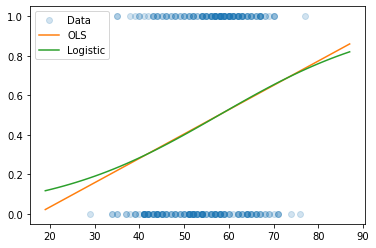

In [112]:
dummy_x=np.linspace(np.min(data_x)-10,np.max(data_x)+10)
yhat_regress = regress1.predict(dummy_x.reshape(-1,1))
plt.plot(data_x, data_y, 'o' ,alpha=0.2, label='Data')
plt.plot(dummy_x, yhat_regress, label = "OLS")

######
# your code here
######

yhat_logit = logit1.predict_proba(dummy_x.reshape(-1,1))[:,1]
plt.plot(dummy_x, yhat_logit, label = "Logistic")
plt.legend()

plt.ylim(-0.05,1.05)
plt.show()

**Solution:**

The predicted curves are very similar (not always the case...especially for multiple predictors) especially where the logistic curve is more-or-less linear (when $0.25<\hat{p}<0.75$).  The logistic curve 'flattens out' and away from the linear model in the extremities of age.

---

## Part 2: More Logistic Regression Modeling 

**Q2.1** Fit a logistic regression model (`logit2`) to predict `AHD` from `Sex`.  Confirm that these estimates are correct based on the contingency table .
Hint: What proportion of women had heart attacks in the dataset?  What proportion of men?

In [113]:
######
# your code here
######

logit2 = LogisticRegression(C=10000,fit_intercept=True).fit(df_heart[['Sex']], df_heart['AHD'])
beta0 = logit2.intercept_[0]
beta1 = logit2.coef_[0][0]

phat_women = logit2.predict_proba(np.array(0).reshape(-1,1))[0][1]
phat_men = logit2.predict_proba(np.array(1).reshape(-1,1))[0][1]



print("Estimated AHD rate for women:",phat_women)
print("Estimated AHD rate for men:",phat_men)



Estimated AHD rate for women: 0.25773409477062215
Estimated AHD rate for men: 0.5533970476694503


In [114]:
table = pd.crosstab(df_heart['Sex'], df_heart['AHD'])
print("Observed AHD rate for women:",table[1][0]/(table[0][0]+table[1][0]))
print("Observed AHD rate for men:",table[1][1]/(table[0][1]+table[1][1]))
table

Observed AHD rate for women: 0.25773195876288657
Observed AHD rate for men: 0.5533980582524272


AHD,0,1
Sex,,
0,72,25
1,92,114


**Q2.2** Fit two more logistic regression models:
- `logit3` to predict `AHD` from `Sex` and `Age`.  
- `logit4` to predict `AHD` from `Sex` and `Age` and the interaction between the two predictors.

What is the difference betwen these two modeling choices (aka, what does the interaction term allow for)?  

In [115]:
######
# your code here
######
df_heart['Sex_Age'] = df_heart['Sex']*df_heart['Age']

logit3 = LogisticRegression(C=10000,fit_intercept=True).fit(df_heart[['Sex','Age']], df_heart['AHD'])
logit4 = LogisticRegression(C=10000,fit_intercept=True).fit(df_heart[['Sex','Age','Sex_Age']], df_heart['AHD'])

print(logit3.intercept_,logit3.coef_)
print(logit4.intercept_,logit4.coef_)

[-4.80773748] [[1.49886961 0.06571138]]
[-4.27401888] [[0.77521675 0.05653474 0.01273001]]


**Answer:**

The difference between these models is the presence of the interaction term (which is estimated to 0.01273) which allows for the effect of Age on AHD to be potentially different for males and females.  It does not require the log-odds scale relationships to be parallel.

**Q2.3** From `logit4` plot the predicted probability of a heart attack as a function of age separately for females and males (2 separate curves).  What do you notice in these curves?

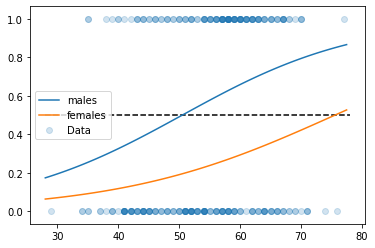

In [42]:
######
# your code here
######

dummy_x = np.arange(np.min(df_heart['Age'])-1,np.max(df_heart['Age'])+1,0.5)
yhat_male = (logit4.intercept_[0]+logit4.coef_[0][0])+(logit4.coef_[0][1]+logit4.coef_[0][2])*dummy_x
yhat_female = (logit4.intercept_[0])+(logit4.coef_[0][1])*dummy_x


#logit4 = LogisticRegression(C=10000,fit_intercept=True).fit(df_heart[['Sex','Age','Sex_Age']], data_y);

plt.scatter(df_heart['Age'], df_heart['AHD'], alpha=0.2, label='Data')
plt.plot(dummy_x,1/(1+np.exp(-yhat_male)),label="males")
plt.plot(dummy_x,1/(1+np.exp(-yhat_female)),label="females")
plt.hlines(0.5,xmin=np.min(df_heart['Age'])-1,xmax=np.max(df_heart['Age'])+1,linestyle="dashed")
plt.legend()
plt.show()

**Solution:**

This plot illustrates that the logistic curves are not just a shift from one to the other (see below for `logit3`).  The plot for males is steeper than it is for females (they have the same 'steepness' in the plot below for `logit3`, just at different values of age.

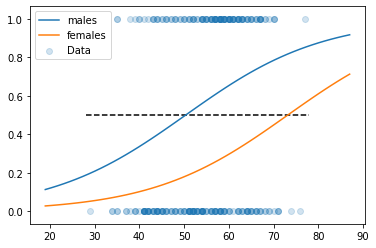

In [116]:
yhat_male = (logit3.intercept_[0]+logit3.coef_[0][0])+(logit3.coef_[0][1])*dummy_x
yhat_female = (logit3.intercept_[0])+(logit3.coef_[0][1])*dummy_x

#logit4 = LogisticRegression(C=10000,fit_intercept=True).fit(df_heart[['Sex','Age','Sex_Age']], data_y);

plt.scatter(df_heart['Age'], df_heart['AHD'], alpha=0.2, label='Data')
plt.plot(dummy_x,1/(1+np.exp(-yhat_male)),label="males")
plt.plot(dummy_x,1/(1+np.exp(-yhat_female)),label="females")
plt.hlines(0.5,xmin=np.min(df_heart['Age'])-1,xmax=np.max(df_heart['Age'])+1,linestyle="dashed")
plt.legend()
plt.show()

**Q2.5** Using `logit4`, at what ages will males be predicted to have a heart attack in a classification?  at what ages will females be predicted to have a heart attack?  Justify based on the plot above.

**Solution:**

The estimated logistic regression model is:
$$\ln\left(\frac{\widehat{P}(Y=1)}{1-\widehat{P}(Y=1)}\right) = -4.27+0.775(Sex)+ 0.05653474(Age)+ 0.0127(Age\times Sex)$$

<ins>For women (Sex=0) this simplifies to:</ins>
$$\ln\left(\frac{\widehat{P}(Y=1)}{1-\widehat{P}(Y=1)}\right) = -4.27+ 0.0565(Age)$$

And solve the RHS for zero:
$$-4.27+ 0.0565(Age)\geq0 \implies Age \geq \frac{4.27}{0.0565} = 75.6$$


<ins>For men (Sex=1) this simplifies to:</ins>
$$\ln\left(\frac{\widehat{P}(Y=1)}{1-\widehat{P}(Y=1)}\right) = -4.27+0.775(1)+ 0.0565(Age)+ 0.0127(Age\times 1)=-3.495 + 0.0692(Age)$$

And solve the RHS for zero:
$$-3.495 + 0.0692(Age)\geq0 \implies Age \geq \frac{3.495}{0.0692} = 50.5$$



---

## Part 3: Classification Accuracy

We split the relevant data into train and test (67-33 split) below for you.  Use this to help score several models we suggest below.

In [77]:
df_heart['Sex_MaxHR']=df_heart['Sex']*df_heart['MaxHR']
df_heart['Age_MaxHR']=df_heart['Age']*df_heart['MaxHR']

X_data = df_heart[['Sex','Age','MaxHR','RestBP','Chol','Sex_Age','Sex_MaxHR','Age_MaxHR']]
y_data = df_heart['AHD']

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_data, y_data, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(203, 8) (100, 8) (203,) (100,)


**Q3.1** Fit an 'unregularized' logistic regression model (`logit5`) to predict `AHD` from all the predictors in the training set.  Determine the misclassification rate in both the train and test sets.

In [78]:
######
# your code here
######

data_x = df_heart[['Sex']]
data_y = df_heart['AHD']
logit5 = LogisticRegression(C=10000,fit_intercept=True).fit(X_train, y_train);

print("Overall misclassification rate in train:",1-logit5.score(X_train,y_train))
print("Overall misclassification rate in test:",1-logit5.score(X_test,y_test))


Overall misclassification rate in train: 0.2660098522167488
Overall misclassification rate in test: 0.31999999999999995


**Q3.2** Fit a 'regularized' logistic regression model (`logit6`) to predict `AHD` from all the predictors in the training set (with `C=0.001`).  Compare the coefficient estimates in `logit6` to `logit5`, and determine the misclassification rate in both the train and test sets.  How have things changed?

In [103]:
######
# your code here
######

logit6 = LogisticRegression(C=0.001,fit_intercept=True).fit(X_train, y_train);



print("Overall misclassification rate in train:",1-logit6.score(X_train,y_train))
print("Overall misclassification rate in test:",1-logit6.score(X_test,y_test))

d = {'logit5': logit5.coef_[0], 'logit6': logit6.coef_[0]}
coefs = pd.DataFrame(data=d)
coefs.index = X_train.columns
coefs

Overall misclassification rate in train: 0.2561576354679803
Overall misclassification rate in test: 0.30000000000000004


,logit5,logit6
Sex,0.001320,0.000606
Age,-0.026397,-0.001357
MaxHR,-0.044734,-0.042043
RestBP,0.020007,0.015779
Chol,0.008168,0.007291
Sex_Age,0.049975,0.032536
Sex_MaxHR,-0.005866,-0.000050
Age_MaxHR,0.000252,0.000135


**Solution:**

Not much has changed: the overall misclassification rate is a little lower for both the train and test sets.



**Q3.3** Calculate the confusion tables in the test set for `logit5` when the cut-off is the typical 0.5 and when it is 0.8.  Calculate the sensitivity and specificity of this classification algorithm fior each of these cut-offs.
Hint: (sk.metrics.confusion_matrix)[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html] will be useful for this task.

In [118]:
yhat_test_logit5 = logit5.predict_proba(X_test)[:,1]
print('The average predicted probability is',np.mean(yhat_test_logit5))

######
# your code here
######

print('The confusion matrix when cut-off is 0.5: \n',sk.metrics.confusion_matrix(y_test, yhat_test>0.5))
print('The confusion matrix when cut-off is 0.75: \n',sk.metrics.confusion_matrix(y_test, yhat_test>0.8))

#print('The confusion matrix when cut-off is',np.mean(yhat),'\n',sk.metrics.confusion_matrix(df_heart['AHD'], yhat>np.mean(yhat)))




The average predicted probability is 0.49112147033649123
The confusion matrix when cut-off is 0.5: 
 [[36 15]
 [15 34]]
The confusion matrix when cut-off is 0.75: 
 [[49  2]
 [34 15]]


0.49

**Solution:**
 
The sensitity is $P(\hat{Y}=1|Y=1) = \frac{34}{34+15} = 0.694$ and specificity is $P(\hat{Y}=0|Y=0) = \frac{36}{36+15} = 0.706$ when the threshold is the standard 0.5. 
    
When the threshold is instead set to 0.8, sensitivity is much lower at $P(\hat{Y}=1|Y=1) = \frac{15}{34+15} = 0.306$ while specificity goes up to $P(\hat{Y}=0|Y=0) = \frac{49}{49+2} = 0.961$.  Note: the overall misclassification rate is higher at the nonstandard threshould: 36/100 vs. 30/100.

The ROC curve for logit5 is shown below using `sk.metrics.roc_curve`:

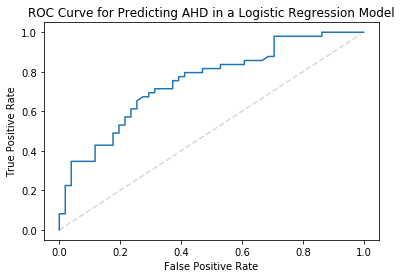

In [82]:
fpr, tpr, thresholds = sk.metrics.roc_curve(y_test, yhat_test)

x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr,tpr)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Predicting AHD in a Logistic Regression Model")
plt.show()

**Q3.4** For `logit6`, determine the predicted probabilties in test and calculate and print the ROC Curve for this model.

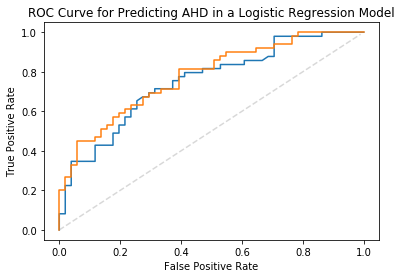

In [119]:
######
# your code here
######
yhat_test_logit6 = logit6.predict_proba(X_test)[:,1]

fpr6, tpr6, thresholds6 = sk.metrics.roc_curve(y_test, yhat_test_logit6)

x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr,tpr,label="logit5")
plt.plot(fpr6,tpr6,label="logit6")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Predicting AHD in a Logistic Regression Model")
plt.show()

**Q3.5** Use the ROC curves above to eyeball which of `logit5` and `logit6` is a better classification model based on Area Under the ROC Curve (AUC).  Then, calculate the actual AUC for these two models. 

Hint: use (sklearn.metrics.auc)[https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html].

In [120]:
######
# your code here
######

print(sk.metrics.auc(fpr,tpr))

print(sk.metrics.auc(fpr6,tpr6))

0.749499799919968
0.7759103641456583


Eyeballing it, it looks like the regularized model is slightly better as measured by AUC, and in fact it is (0.7759 vs. 0.7495 for the unregularized version).  This is not always the pattern, and this could certainly be improved by tuning the regularization hyperparameter to improve out-of-sample prediction (which was not done here).